# Exploring the WCWH Ambassador Family Beacon IAQ Data
(See [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Comparing Ambassador Family Data to UTx000 Data
A look ath the differences in measurements made between the two cohorts.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Package Import

In [2]:
import sys
sys.path.append('../')

from src.visualization import visualize
from src.exploration import beacon_summary
from src.analysis import iaq_comparison

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from datetime import datetime, timedelta

# Table of Contents
1. [Notes on Analysis and References](#refs)
2. [Data Notes and Import](#import)
3. [Operation and Available Data](#operation)
4. [Statistical Summary](#statistics)
5. [Participant Summary and Diagnosis](#pt-based)

---

<a id="refs"></a>

# Notes on Analysis and References
The analyses in this notebook are primarily surface-level, but are described briefly below.

## UTx000 Participants to Consider
We only want to consider participants that collected data in Austin, namely in Central Austin. This limits the beacon data to the following devices:

```python
beacon_ux_aus = [1,5,10,11,13,22,23,25,28,29,30,34,40,48]
```

## WCWH Ambassador Families to Consider
The ambassador families represent those that signed on for a beta test of all our protocol including the BEVO Beacon. The following devices were included in the rollout:

```python
beacon_af = [1,5,6,15,16,19,24,25,29,30,34,36,38,44]
```

## Comparison
We consider a few types of statistical tests to compare the distributions:
1. Mood's Median: compares the medians between distributions
2. Welch's t-Test: compares the means between distributions
3. Mixed Anova: _needs some work_

These analyses help us determine to what extent the measurements between these groups differ. 

## References
Some of the references used for analysis as well as for programming.

### Programming
1. [Legend on Seaborn Plots](https://stackoverflow.com/questions/64014746/how-do-you-create-a-legend-for-kde-plot-in-seaborn)
2. [Remove Legend](https://stackoverflow.com/questions/5735208/remove-the-legend-on-a-matplotlib-figure)
1. [Running Linear Mixed Effects Models in Python](https://towardsdatascience.com/how-to-run-linear-mixed-effects-models-in-python-jupyter-notebooks-4f8079c4b589): For the LME analysis.

---

<a id="import"></a>

# Data Notes and Import
Some notes on the data we use and then importing the actual data to look at.

## Beacon Data
For once we just need data from one modality...at least for the time-being. Data are combined elsewhere from each of the Beacons, but the source code for this project selects the relevant Beacon data. 

## `Compare` Object
The source code for this project lives in `/src/analysis/iaq_comparison.py`. We create a `Compare` object which imports the data and provides methods for statistical analysis and visualization.

In [11]:
comparison = iaq_comparison.Compare(study1="ux_s20",study2="wcwh_s21",
                                   beacons1=[1,5,10,11,13,22,23,25,28,29,30,34,40,48],
                                   beacons2=[1,5,15,16,24,25,29,30,34,36,38,44],
                                   remove_outliers=True)

---

<a id="operation"></a>

# Visualizations
A look at the differences between measurements

## Distributions of Values: Density Plots
We look at these more with the violin plots, but these are a nice, initial look

### Carbon Dioxide
**Hypothesis**: Concentrations are higher for ambassador families since they likely have less square footage per occupant.

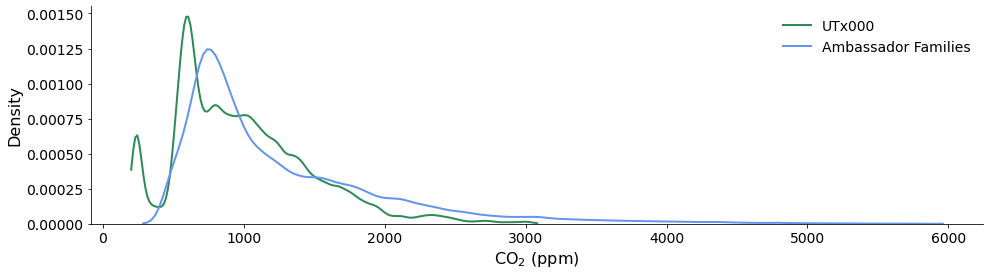

In [7]:
comparison.plot_kde(param="co2",)

<div class="alert alert-block alert-success">
 
Our hypothesis seems to be correct at least in general.
    
</div>

#### Participant Inspection

<div class="alert alert-block alert-warning">
 
Concentrations seem to be heavily skewed toward high values which makes me think one participant is the cause since the density values are so low. 
    
</div>

In [12]:
amb_summary = beacon_summary.Summarize("wcwh_ambassador","wcwh_s21")

Plotting for Beacon: 1


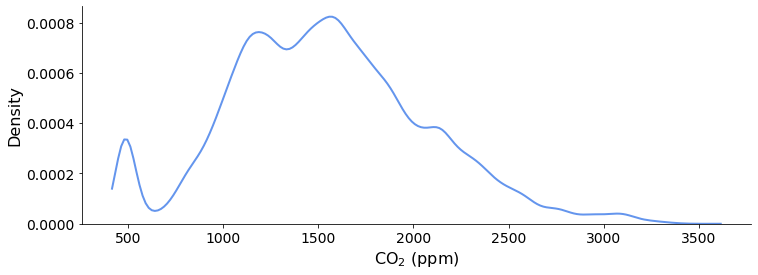

Plotting for Beacon: 5


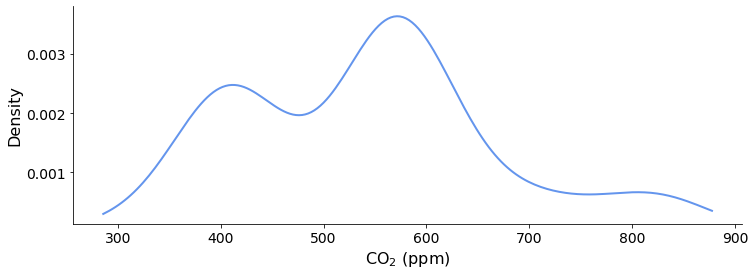

Plotting for Beacon: 15


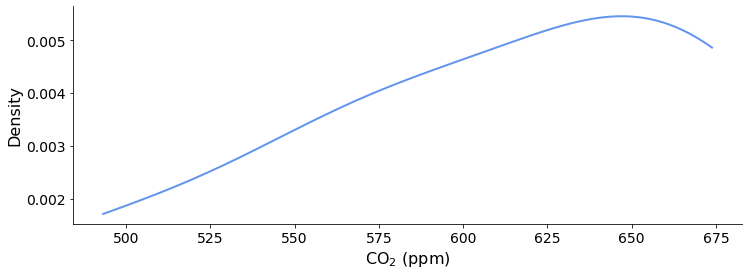

Plotting for Beacon: 16


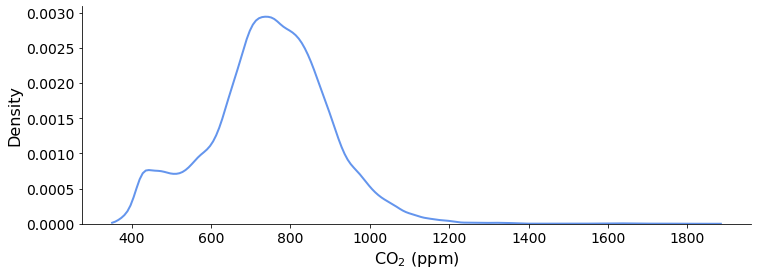

Plotting for Beacon: 24


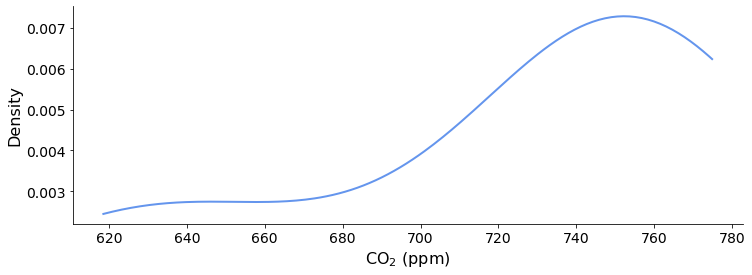

Plotting for Beacon: 25


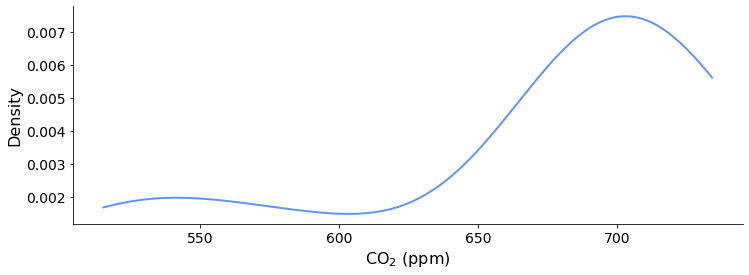

Plotting for Beacon: 29


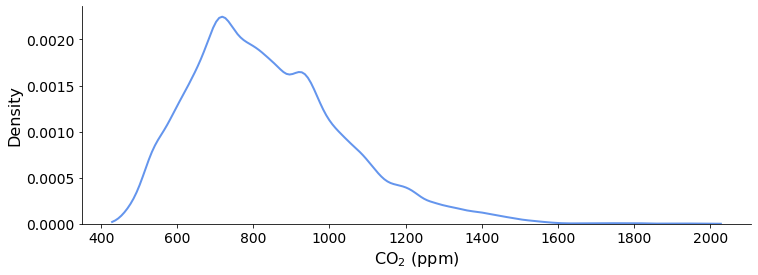

Plotting for Beacon: 30


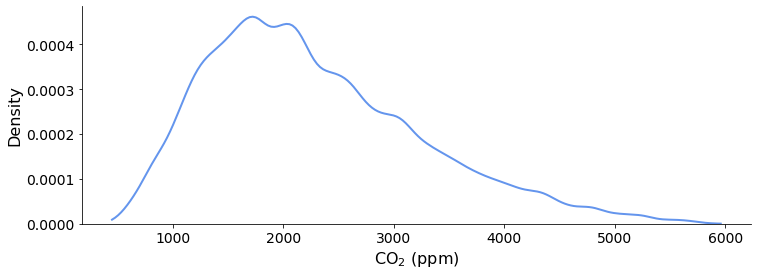

Plotting for Beacon: 34


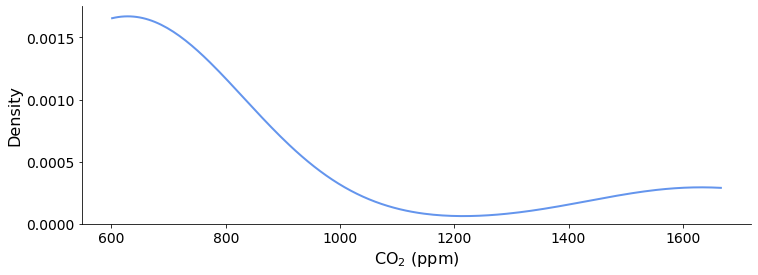

Plotting for Beacon: 36


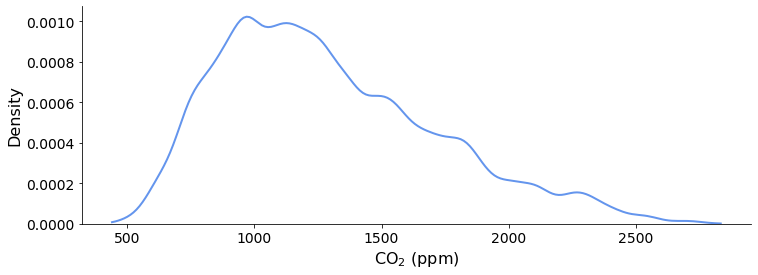

Plotting for Beacon: 38


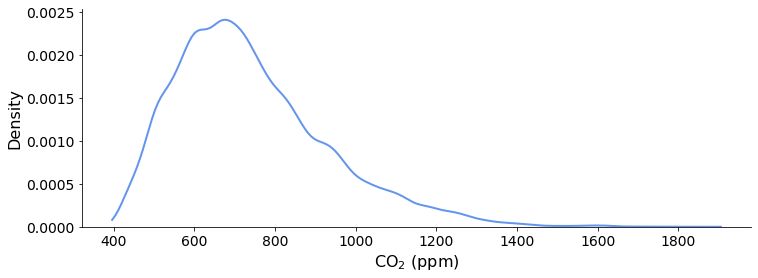

Plotting for Beacon: 44


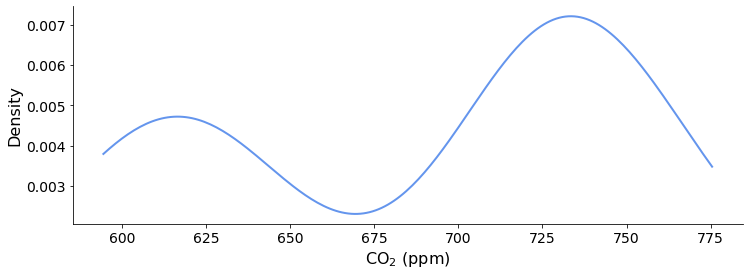

In [15]:
for bb in comparison.bb2:
    print("Plotting for Beacon:",bb)
    amb_summary.plot_distributions(data=amb_summary.get_beacon(bb),params=["co2"])

<div class="alert alert-block alert-warning">
 
Beacon 30 is the only contributor to elevated CO2 above 4000 ppm but the data look rather normally distributed so nothing to really worry about. 
    
</div>

## Boxplot

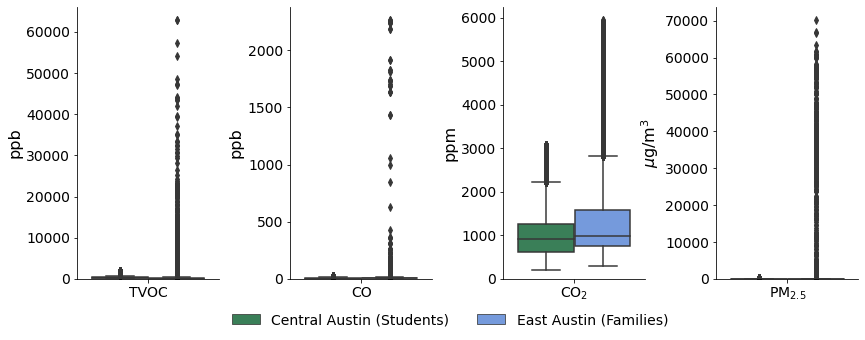

In [8]:
comparison.plot_boxplot_comparison(study1="Central Austin (Students)", study2="East Austin (Families)", save=False)

## Violins

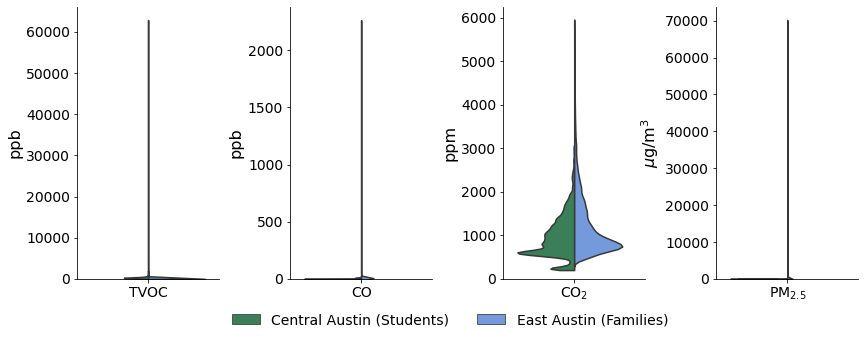

In [9]:
comparison.plot_violin_comparison(study1="Central Austin (Students)", study2="East Austin (Families)", save=False)

<div class="alert alert-block alert-info">
 
IAQ seems to be worse in the homes of the ambassador families except when considering `tvoc` although there is a wider range and more extreme outliers.
    
</div>

---

<a id="statistics"></a>

# Statistics
Summary stats and some more involved analysis

## Summary
Summary statistics from the two studies

In [16]:
def get_summary_stats(df,params=["tvoc","co","co2","pm2p5_mass"],resample=1):
    """Gets summary statistics for the given dataframe"""
    
    df = resample_data(df,resample_rate=resample)
    
    res = {"n":[],"min":[],"25":[],"median":[],"75":[],"max":[]}
    for param in params:
        for key, val in zip(res.keys(),[len(df[param].dropna()),np.nanmin(df[param]),np.nanpercentile(df[param],25),
                                        np.nanmedian(df[param]),np.nanpercentile(df[param],75),
                                        np.nanmax(df[param])]):
            res[key].append(val)
        
    return pd.DataFrame(res,index=params)

### UTx000

In [17]:
get_summary_stats(data_ux,resample=60)

,n,min,25,median,75,max
tvoc,16266,0.000000,149.172600,246.062059,349.980061,703.436190
co,16225,0.000000,0.000000,0.580360,4.452989,14.623800
co2,15927,202.742629,618.474295,889.280057,1232.561756,2208.409480
pm2p5_mass,17268,0.000000,6.788126,11.058977,17.644154,51.751534


### Ambassador Families

In [18]:
get_summary_stats(data_af,resample=60)

,n,min,25,median,75,max
tvoc,2120,0.000000,10.531583,43.600816,182.816582,1140.499291
co,2093,-1.028789,6.985136,8.168571,11.588312,24.208067
co2,2176,466.895305,1102.419848,1512.704627,1911.682122,3085.989046
pm2p5_mass,2109,-0.550154,4.036661,6.751274,17.475367,122.273756


## Mood's Median Test
Like Welch's t-Test, but on the medians of the distributions rather than the means.

In [19]:
from scipy.stats import median_test

In [20]:
params=["tvoc","co","co2","pm2p5_mass"]
for param in params:
    stat, p, m, table = median_test(data_ux[param].values, data_af[param].values,nan_policy="omit")
    print(f"{param}: {p}")

tvoc: 4.5481179631527534e-194
co: 0.0
co2: 1.036570305940788e-205
pm2p5_mass: 2.1885043983985482e-44


<div class="alert alert-block alert-success">
 
The medians are _significantly_ different between distributions.
    
</div>

## Welch's t-Test

In [21]:
from scipy.stats import ttest_ind

In [22]:
params=["tvoc","co","co2","pm2p5_mass"]
for param in params:
    t, p = ttest_ind(data_ux[param].values, data_af[param].values,equal_var=False,nan_policy="omit")
    print(f"{param}: {p}")

tvoc: 5.374859597449729e-161
co: 0.0
co2: 0.0
pm2p5_mass: 9.324400101217285e-18


<div class="alert alert-block alert-success">
 
Even more so, the means of the distributions are _significantly_ different between distributions.
    
</div>

## Mixed ANOVA/Split-Plot ANOVA
Learn more [here](https://statistics.laerd.com/spss-tutorials/mixed-anova-using-spss-statistics.php)

In [23]:
def combine_and_resample(df1, df2, study1="UTx000", study2="Ambassador Families", resample_rate=1, remove_na=True):
    """
    Combines, adds labels, resamples, and [maybe] drops NaN
    
    Parameters
    ----------
    
    Returns
    -------
    df : DataFrame
        cleaned dataframe
    """
    # Resampling
    # ----------
    ## Have to separate by beacon so that I don't resample the beacon number...
    ## Study 1
    df1_resampled = pd.DataFrame()
    for bb in df1["beacon"].unique():
        df_bb = df1[df1["beacon"] == bb]
        df_bb_resampled = df_bb.resample(f"{resample_rate}T").mean()
        df_bb_resampled["beacon"] = bb
        df1_resampled = df1_resampled.append(df_bb_resampled)
    ## Study 2
    df2_resampled = pd.DataFrame()
    for bb in df2["beacon"].unique():
        df_bb = df2[df2["beacon"] == bb]
        df_bb_resampled = df_bb.resample(f"{resample_rate}T").mean()
        df_bb_resampled["beacon"] = bb
        df2_resampled = df2_resampled.append(df_bb_resampled)
        
    # Labeling
    df1_resampled["study"] = study1
    df2_resampled["study"] = study2
    
    # Combining
    df = df1_resampled.append(df2_resampled)
    
    # Removing NaN
    if remove_na:
        df.dropna(how="any",inplace=True)
    
    return df

In [24]:
data = combine_and_resample(data_ux, data_af, resample_rate=60)

In [25]:
data.head()

,tvoc,co,co2,pm2p5_mass,beacon,study
timestamp,,,,,,
2020-06-09 11:00:00,0.000000,14.306310,615.663016,32.940397,1,UTx000
2020-06-09 12:00:00,0.135472,13.013227,636.839059,31.332884,1,UTx000
2020-06-09 13:00:00,3.064409,11.913453,633.773553,31.026540,1,UTx000
2020-06-09 14:00:00,9.153643,11.171782,659.136100,45.666537,1,UTx000
2020-06-09 15:00:00,14.175602,10.744059,667.008284,43.505947,1,UTx000


---

<a id="pt-based"></a>

# Participant-Based Summary

## UTx000 Example Data

In [42]:
ux = beacon_summary.Summarize(study="utx000",suffix="ux_s20")

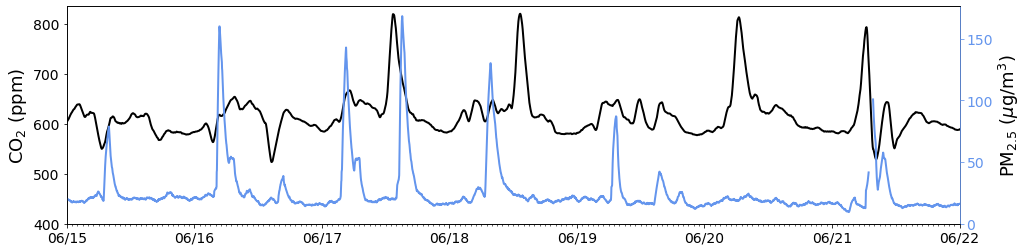

In [48]:
ux.plot_two_var_ts(beacon=1,start_time=datetime(2020,6,15),end_time=datetime(2020,6,22),save=True,annot="iaq_ex")

## Ambassador Family Example Data

In [44]:
wcwh = beacon_summary.Summarize(study="wcwh_pilot",suffix="wcwh_s21")

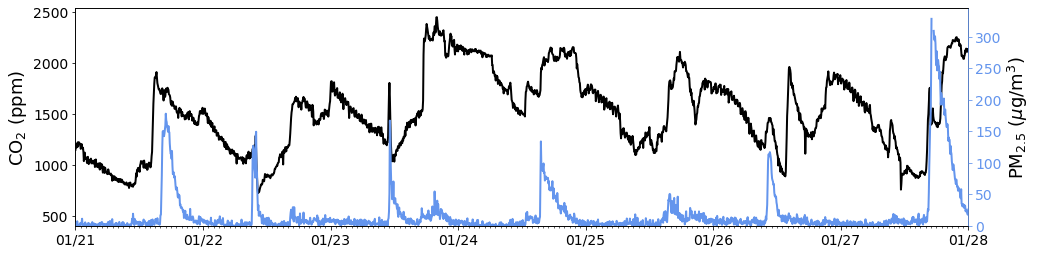

In [47]:
wcwh.plot_two_var_ts(beacon=1,start_time=datetime(2022,1,21),end_time=datetime(2022,1,28),save=True,annot="iaq_ex")

---